<a href="https://colab.research.google.com/github/zaraaa12/Machine_Learning/blob/main/tesla_nlp2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re

import spacy
from gensim import corpora, models
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/td-csv.csv", encoding='latin1')

In [ ]:
df.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,AutoPilot claimed,Reported in NHTSA SGO,Verified Tesla Autopilot Death,Excerpt Verifying Tesla Autopilot Deaths,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,560.0,2025.0,10/31/2025,USA,AZ,Tesla hit by car,1,1,-,-,...,-,-,-,-,https://archive.ph/r6Ls2,NaN,NaN,NaN,NaN,NaN
1,559.0,2025.0,10/29/2025,UK,-,Tesla crashes into wooded area,1,1,-,-,...,-,-,-,-,https://archive.ph/OIdTO,NaN,Samuel Tremblett,NaN,NaN,NaN
2,558.0,2025.0,10/28/2025,USA,MA,Tesla catches on fire,1,1,-,-,...,-,-,-,-,https://web.archive.org/web/20251103080425/htt...,NaN,NaN,NaN,NaN,NaN
3,557.0,2025.0,10/28/2025,USA,TX,Car crashes into Tesla head-on,2,1,-,1,...,-,-,-,-,https://archive.ph/wip/vlcvg,NaN,NaN,NaN,NaN,NaN
4,556.0,2025.0,10/26/2025,USA,FL,Tesla stops and hit by semi,1,1,-,-,...,1,13781-11878,1,SGO,https://web.archive.org/web/20251123024415/htt...,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Case #                                    611 non-null    float64
 1   Year                                      611 non-null    float64
 2   Date                                      611 non-null    object 
 3   Country                                   611 non-null    object 
 4   State                                     611 non-null    object 
 5   Description                               611 non-null    object 
 6   Deaths                                    611 non-null    int64  
 7   Tesla driver                              600 non-null    object 
 8   Tesla occupant                            598 non-null    object 
 9   Other vehicle                             599 non-null    object 
 10  Cyclists/ Peds                        

In [ ]:
df.describe()

,Case #,Year,Deaths
count,611.000000,611.000000,611.000000
mean,291.442226,2019.455155,1.263502
std,160.816028,64.411864,0.614812
min,1.000000,431.100000,1.000000
25%,152.500000,2021.000000,1.000000
50%,302.000000,2023.000000,1.000000
75%,433.050000,2024.000000,1.000000
max,560.000000,2025.000000,5.000000


In [ ]:
df.isnull().sum()

,0
Case #,0
Year,0
Date,0
Country,0
State,0
Description,0
Deaths,0
Tesla driver,11
Tesla occupant,13
Other vehicle,12


In [ ]:
df.columns = df.columns.str.strip()
df = df.dropna(subset=['Year', 'Deaths']).copy()
df = df[df['Year'] >= 1900].copy() # Filter out unrealistic years like 202.0

df['Year'] = df['Year'].astype(int)
df['Deaths'] = df['Deaths'].astype(int)

print(f"Data type of 'Year' after cleaning: {df['Year'].dtype}")
print(f"Number of nulls in 'Year' after cleaning: {df['Year'].isnull().sum()}\n")

print(f"Data type of 'Deaths' after cleaning: {df['Deaths'].dtype}")
print(f"Number of nulls in 'Deaths' after cleaning: {df['Deaths'].isnull().sum()}")

Data type of 'Year' after cleaning: int64
Number of nulls in 'Year' after cleaning: 0

Data type of 'Deaths' after cleaning: int64
Number of nulls in 'Deaths' after cleaning: 0


In [ ]:
annual_deaths = df.groupby('Year')['Deaths'].sum()
print("Annual deaths after ensuring Year is int:")
print(annual_deaths)

Annual deaths after ensuring Year is int:
Year
2013      3
2014      6
2015      5
2016     16
2017     11
2018     21
2019     51
2020     47
2021     76
2022    119
2023    144
2024    151
2025    121
Name: Deaths, dtype: int64


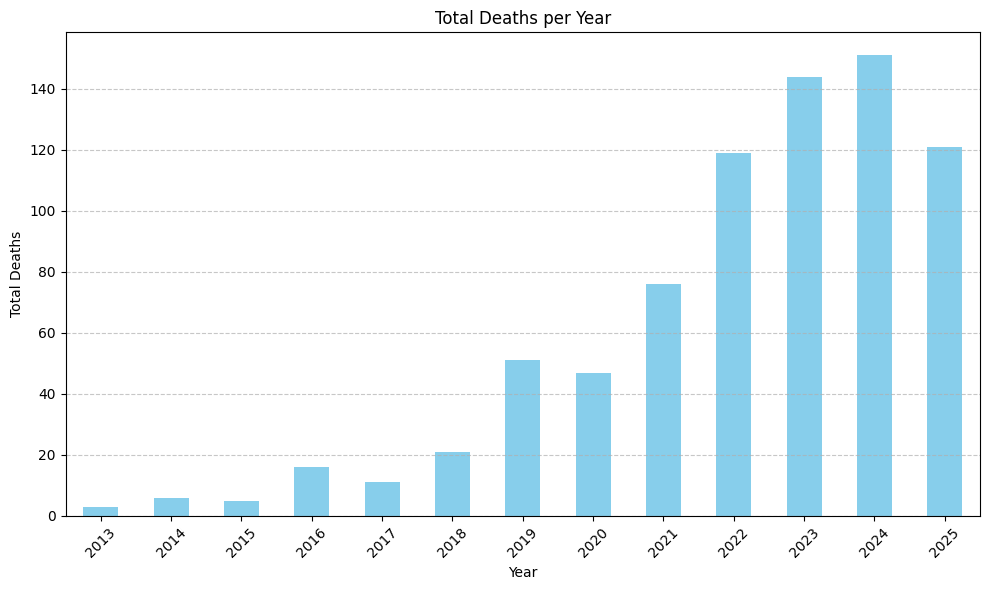

In [ ]:
plt.figure(figsize=(10, 6))
annual_deaths.plot(kind='bar', color='skyblue')
plt.title('Total Deaths per Year')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    text = str(text).lower()  # Convert to string and lowercase
    text = re.sub(r'[^À-῿Ⰰ-퟿豈-﷏ﷰ-￯ -⁯\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers

    doc = nlp(text)
    processed_tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha:  # Remove stopwords and keep only alphabetic tokens
            processed_tokens.append(token.lemma_)
    return ' '.join(processed_tokens)

# Handle potential NaN values in 'Description' by filling them with an empty string
df['Description'] = df['Description'].fillna('')

# Apply the preprocessing function to the 'Description' column
df['Processed_Description'] = df['Description'].apply(preprocess_text)

print("Preprocessing of 'Description' column complete. First 5 processed descriptions:")
print(df['Processed_Description'].head())

Preprocessing of 'Description' column complete. First 5 processed descriptions:
0             tesla hit car
1    tesla crash woode area
2          tesla catch fire
3    car crash tesla headon
4       tesla stop hit semi
Name: Processed_Description, dtype: object


In [ ]:
tokenized_descriptions = [doc.split() for doc in df['Processed_Description']]
print("First 5 tokenized descriptions:")
print(tokenized_descriptions[:5])

First 5 tokenized descriptions:
[['tesla', 'hit', 'car'], ['tesla', 'crash', 'woode', 'area'], ['tesla', 'catch', 'fire'], ['car', 'crash', 'tesla', 'headon'], ['tesla', 'stop', 'hit', 'semi']]


In [ ]:
dictionary = corpora.Dictionary(tokenized_descriptions)
print(f"Number of unique words in dictionary: {len(dictionary)}")

Number of unique words in dictionary: 342


In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in tokenized_descriptions]
print("First 5 entries of the corpus (bag-of-words representation):")
print(corpus[:5])

First 5 entries of the corpus (bag-of-words representation):
[[(0, 1), (1, 1), (2, 1)], [(2, 1), (3, 1), (4, 1), (5, 1)], [(2, 1), (6, 1), (7, 1)], [(0, 1), (2, 1), (4, 1), (8, 1)], [(1, 1), (2, 1), (9, 1), (10, 1)]]


In [ ]:
num_topics = 5
lda_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, workers=2)

print(f"LDA model trained with {num_topics} topics.")
print("Top words for each topic:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

LDA model trained with 5 topics.
Top words for each topic:
Topic 0: 0.145*"tesla" + 0.093*"driver" + 0.079*"kill" + 0.040*"die" + 0.037*"pedestrian" + 0.036*"hit" + 0.032*"motorcyclist" + 0.023*"car" + 0.021*"strike" + 0.020*"later"
Topic 1: 0.211*"tesla" + 0.101*"crash" + 0.089*"hit" + 0.055*"tree" + 0.033*"car" + 0.033*"fire" + 0.027*"ignite" + 0.027*"run" + 0.025*"motorcycle" + 0.022*"catch"
Topic 2: 0.198*"tesla" + 0.112*"hit" + 0.065*"car" + 0.062*"crash" + 0.042*"pedestrian" + 0.031*"burn" + 0.027*"collide" + 0.013*"oncoming" + 0.013*"road" + 0.012*"stop"
Topic 3: 0.105*"tesla" + 0.087*"accident" + 0.066*"multicar" + 0.052*"highway" + 0.045*"crash" + 0.039*"involve" + 0.026*"strike" + 0.025*"guardrail" + 0.019*"drive" + 0.016*"intersection"
Topic 4: 0.158*"collision" + 0.079*"headon" + 0.078*"tesla" + 0.073*"oui" + 0.063*"car" + 0.034*"lane" + 0.025*"truck" + 0.025*"veer" + 0.015*"crash" + 0.012*"opposite"


In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.525283951327639


In [ ]:
def extract_entities(text):
    doc = nlp(str(text))
    return [(ent.text, ent.label_) for ent in doc.ents]

df['Extracted_Entities'] = df['Description'].apply(extract_entities)

print("First 5 entries of 'Description' and 'Extracted_Entities':")
print(df[['Description', 'Extracted_Entities']].head())

First 5 entries of 'Description' and 'Extracted_Entities':
                      Description Extracted_Entities
0                Tesla hit by car                 []
1  Tesla crashes into wooded area                 []
2           Tesla catches on fire                 []
3  Car crashes into Tesla head-on                 []
4     Tesla stops and hit by semi                 []


In [ ]:
nlp = spacy.load('en_core_web_sm') # Re-load spaCy model, enabling NER by default

def extract_entities(text):
    doc = nlp(str(text))
    return [(ent.text, ent.label_) for ent in doc.ents]

df['Extracted_Entities'] = df['Description'].apply(extract_entities)

print("First 5 entries of 'Description' and 'Extracted_Entities' after re-enabling NER:")
print(df[['Description', 'Extracted_Entities']].head())

First 5 entries of 'Description' and 'Extracted_Entities' after re-enabling NER:
                      Description Extracted_Entities
0                Tesla hit by car                 []
1  Tesla crashes into wooded area                 []
2           Tesla catches on fire                 []
3  Car crashes into Tesla head-on     [(Tesla, ORG)]
4     Tesla stops and hit by semi                 []


In [ ]:
from collections import Counter

all_entity_labels = []
for entities_list in df['Extracted_Entities']:
    for entity_text, entity_label in entities_list:
        all_entity_labels.append(entity_label)

label_counts = Counter(all_entity_labels)

print("Distribution of Extracted Entity Labels:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

Distribution of Extracted Entity Labels:
ORG: 146
CARDINAL: 42
PERSON: 19
NORP: 18
GPE: 6
DATE: 2
PRODUCT: 2
QUANTITY: 1
TIME: 1


In [ ]:
entity_counts_per_year = {}

for index, row in df.iterrows():
    year = row['Year']
    entities = row['Extracted_Entities']

    if year not in entity_counts_per_year:
        entity_counts_per_year[year] = Counter()

    for entity_text, entity_label in entities:
        entity_counts_per_year[year][entity_label] += 1

print("Yearly entity counts compiled.")

Yearly entity counts compiled.


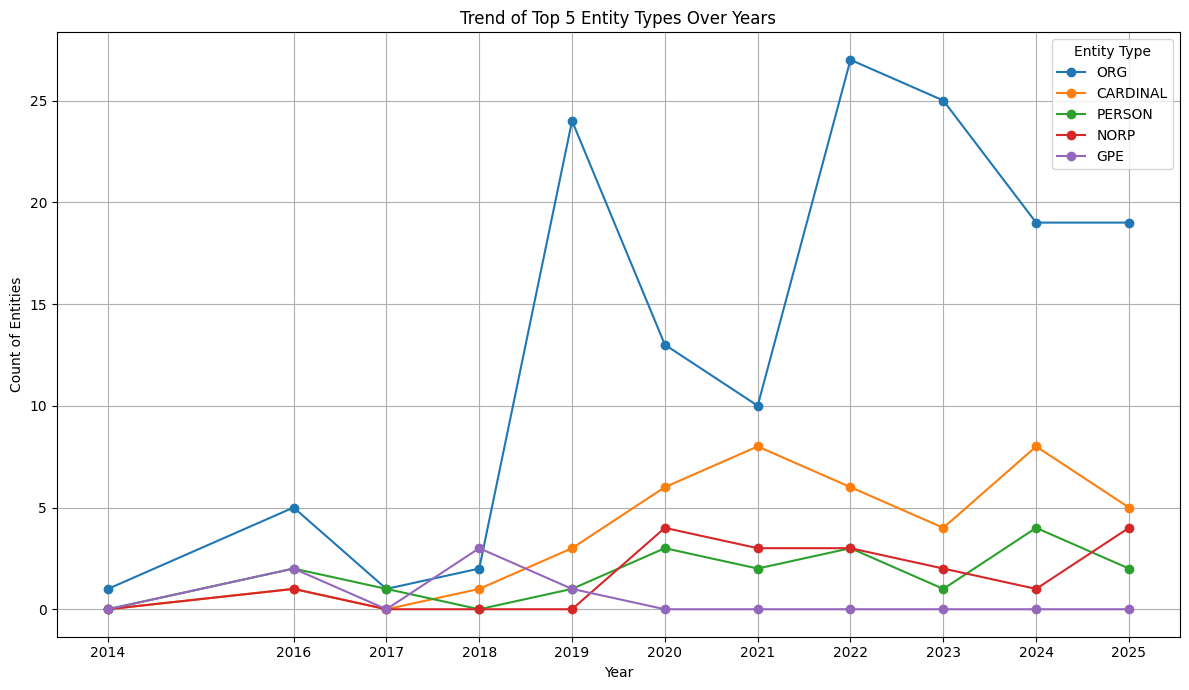

In [ ]:
entity_trends_df = pd.DataFrame.from_dict(entity_counts_per_year, orient='index').fillna(0)
entity_trends_df.index.name = 'Year'

# Select the top 5 most frequent entity labels based on the overall distribution
top_5_entity_labels = [label for label, count in label_counts.most_common(5)]

plt.figure(figsize=(12, 7))
for label in top_5_entity_labels:
    if label in entity_trends_df.columns:
        plt.plot(entity_trends_df.index, entity_trends_df[label], marker='o', label=label)

plt.title('Trend of Top 5 Entity Types Over Years')
plt.xlabel('Year')
plt.ylabel('Count of Entities')
plt.xticks(entity_trends_df.index)
plt.grid(True)
plt.legend(title='Entity Type')
plt.tight_layout()
plt.show()

## Trend and Topic Visualization

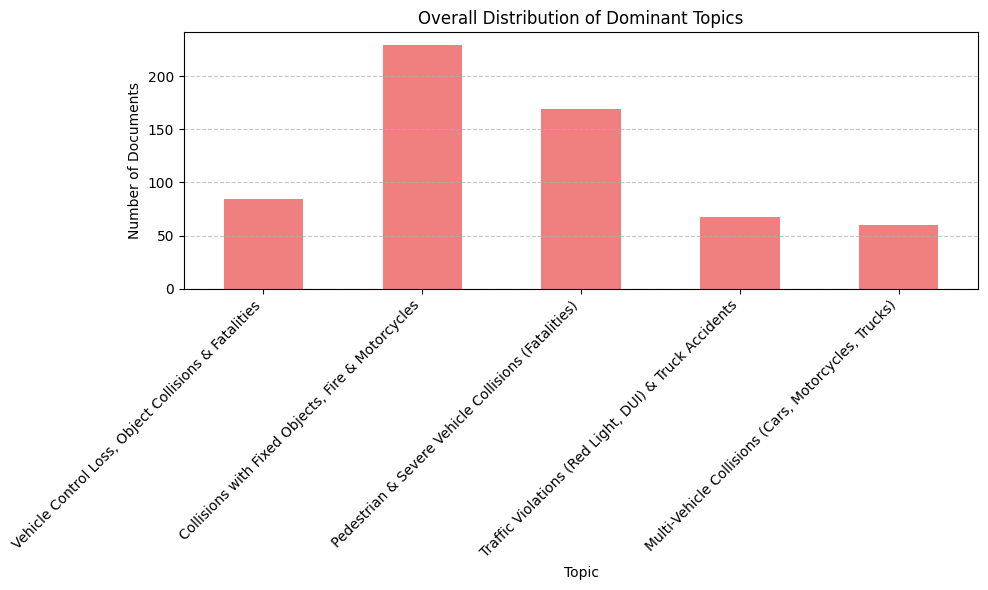

In [ ]:
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

def get_dominant_topic(doc_topics):
    if not doc_topics:
        return None
    # Get the topic with the highest probability
    dominant_topic = max(doc_topics, key=lambda x: x[1])
    return dominant_topic[0]

df['dominant_topic'] = [get_dominant_topic(td) for td in topic_distribution]

topic_counts = df['dominant_topic'].value_counts().sort_index()

# Map topic IDs to more descriptive names based on earlier interpretation
topic_names = {
    0: "Vehicle Control Loss, Object Collisions & Fatalities",
    1: "Collisions with Fixed Objects, Fire & Motorcycles",
    2: "Pedestrian & Severe Vehicle Collisions (Fatalities)",
    3: "Traffic Violations (Red Light, DUI) & Truck Accidents",
    4: "Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)"
}
topic_counts.index = topic_counts.index.map(topic_names)

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='lightcoral')
plt.title('Overall Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

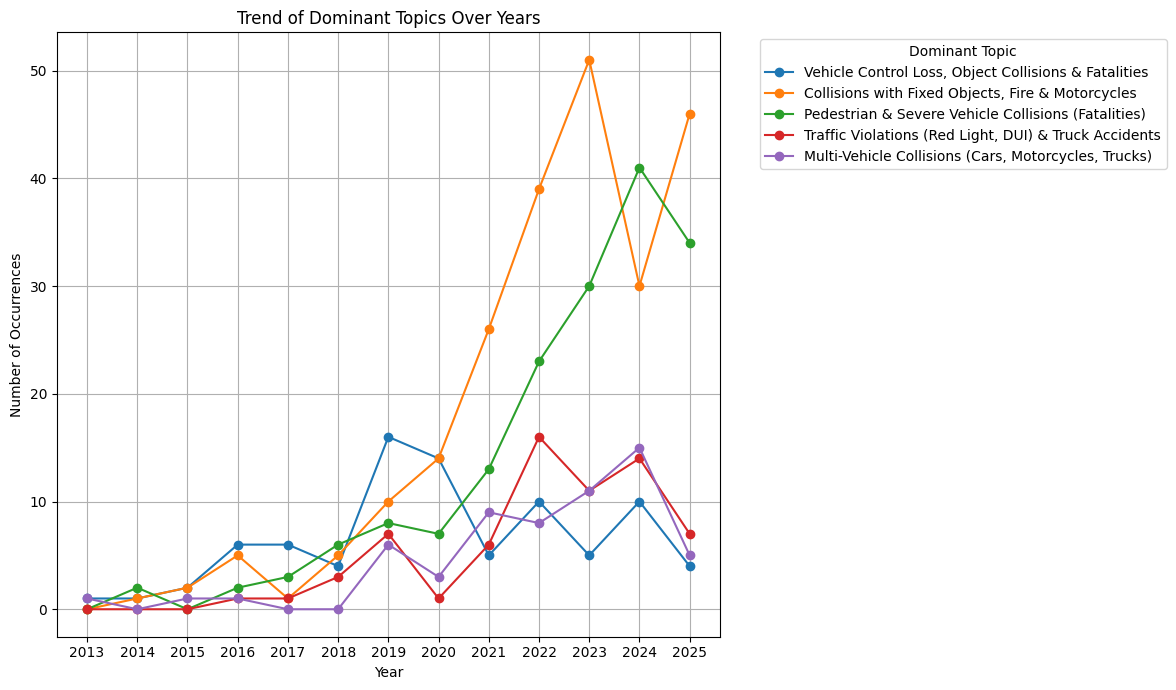

In [ ]:
topic_trends_per_year = df.groupby('Year')['dominant_topic'].value_counts().unstack(fill_value=0)

# Map topic IDs to descriptive names for the plot
topic_trends_per_year = topic_trends_per_year.rename(columns=topic_names)

plt.figure(figsize=(12, 7))
for topic_name in topic_trends_per_year.columns:
    plt.plot(topic_trends_per_year.index, topic_trends_per_year[topic_name], marker='o', label=topic_name)

plt.title('Trend of Dominant Topics Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.xticks(topic_trends_per_year.index)
plt.grid(True)
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

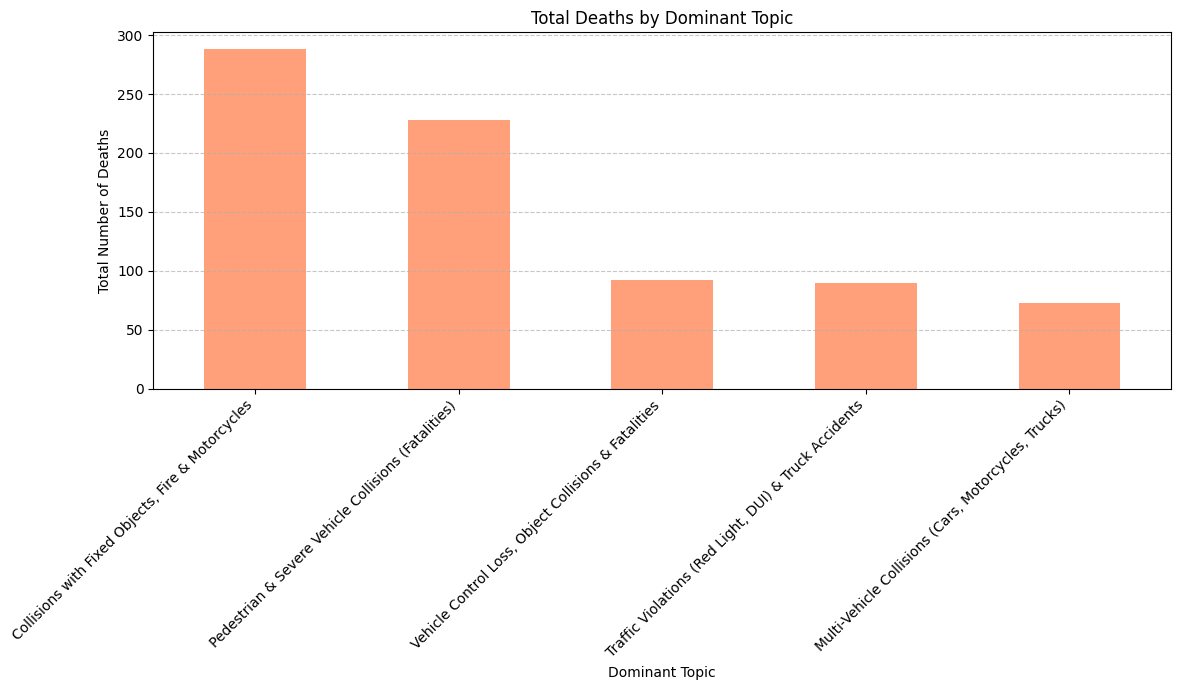


Total kematian per insiden berdasarkan Topik Dominan:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        288
Pedestrian & Severe Vehicle Collisions (Fatalities)      228
Vehicle Control Loss, Object Collisions & Fatalities      92
Traffic Violations (Red Light, DUI) & Truck Accidents     90
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)      73
Name: Deaths, dtype: int64


In [ ]:
# Calculate the total number of deaths for each dominant topic
total_deaths_per_topic = df.groupby('dominant_topic')['Deaths'].sum().sort_values(ascending=False)

# Map topic IDs to descriptive names
total_deaths_per_topic.index = total_deaths_per_topic.index.map(topic_names)

plt.figure(figsize=(12, 7))
total_deaths_per_topic.plot(kind='bar', color='lightsalmon')
plt.title('Total Deaths by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTotal kematian per insiden berdasarkan Topik Dominan:")
print(total_deaths_per_topic)

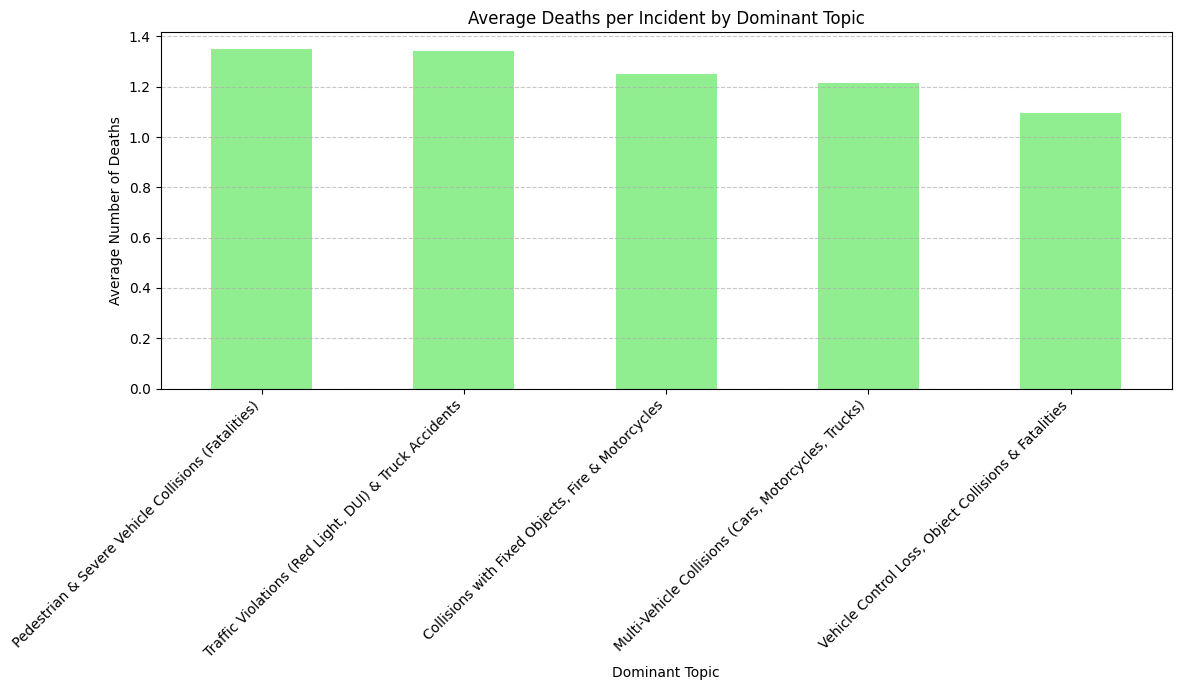


Rata-rata kematian per insiden berdasarkan Topik Dominan:
dominant_topic
Pedestrian & Severe Vehicle Collisions (Fatalities)      1.349112
Traffic Violations (Red Light, DUI) & Truck Accidents    1.343284
Collisions with Fixed Objects, Fire & Motorcycles        1.252174
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)     1.216667
Vehicle Control Loss, Object Collisions & Fatalities     1.095238
Name: Deaths, dtype: float64


In [ ]:
# Calculate the average number of deaths for each dominant topic
average_deaths_per_topic = df.groupby('dominant_topic')['Deaths'].mean().sort_values(ascending=False)

# Map topic IDs to descriptive names
average_deaths_per_topic.index = average_deaths_per_topic.index.map(topic_names)

plt.figure(figsize=(12, 7))
average_deaths_per_topic.plot(kind='bar', color='lightgreen')
plt.title('Average Deaths per Incident by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Average Number of Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nRata-rata kematian per insiden berdasarkan Topik Dominan:")
print(average_deaths_per_topic)

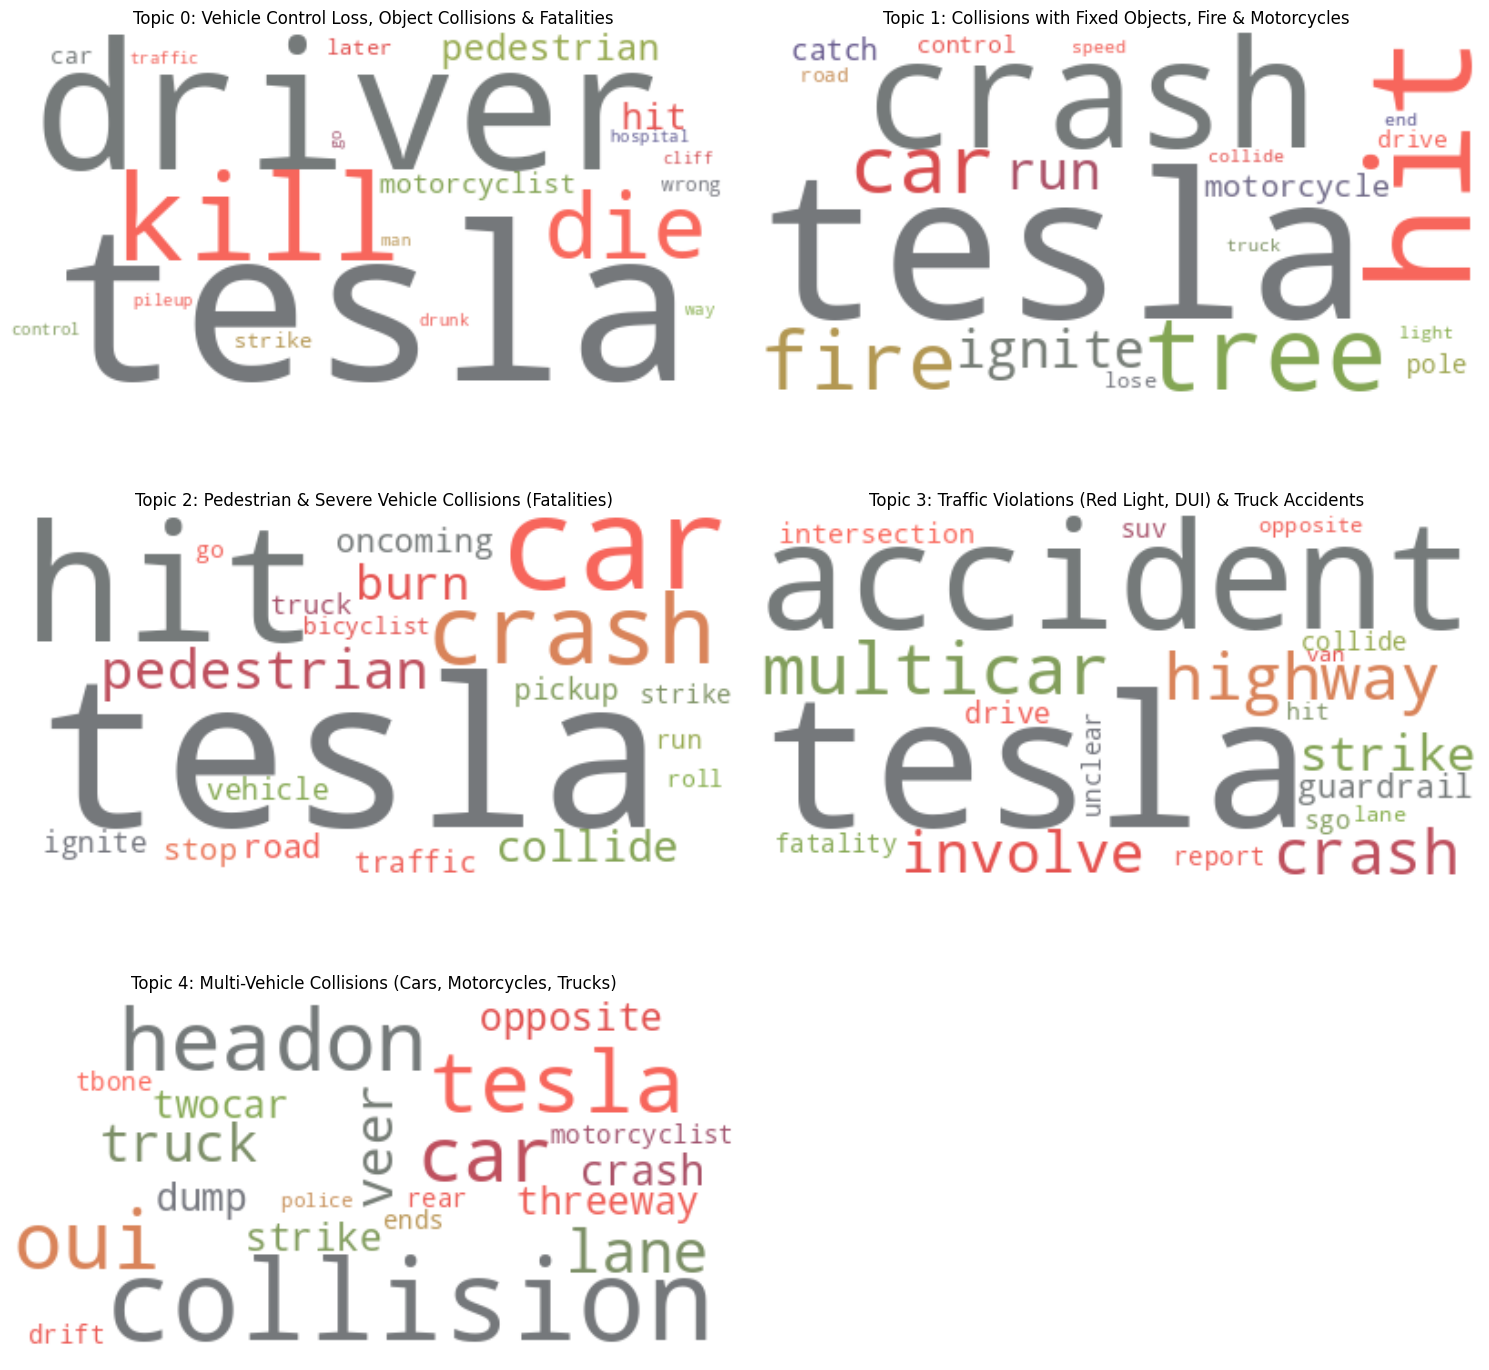

Word Clouds for each topic generated, visualizing key accident factors.


In [ ]:
from wordcloud import WordCloud
import matplotlib.colors

# Define a color map for the word clouds
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["#6B5B95", "#88B04B", "#FF6F61", "#DE4C4C", "#5B5B95"])

# Prepare to plot word clouds for each topic
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, (idx, topic) in enumerate(lda_model.print_topics(num_words=10)):
    if i < len(axes):
        # Extract words and their weights
        words_weights = {word: float(weight) for word, weight in lda_model.show_topic(idx, topn=20)}

        wc = WordCloud(background_color="white",
                       max_words=1000,
                       contour_width=3,
                       contour_color='steelblue',
                       colormap=colormap,
                       random_state=42)

        # Generate word cloud from words_weights
        wc.generate_from_frequencies(words_weights)

        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"Topic {idx}: {topic_names.get(idx, f'Topic {idx}')}", fontsize=12)
        axes[i].axis("off")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Word Clouds for each topic generated, visualizing key accident factors.")

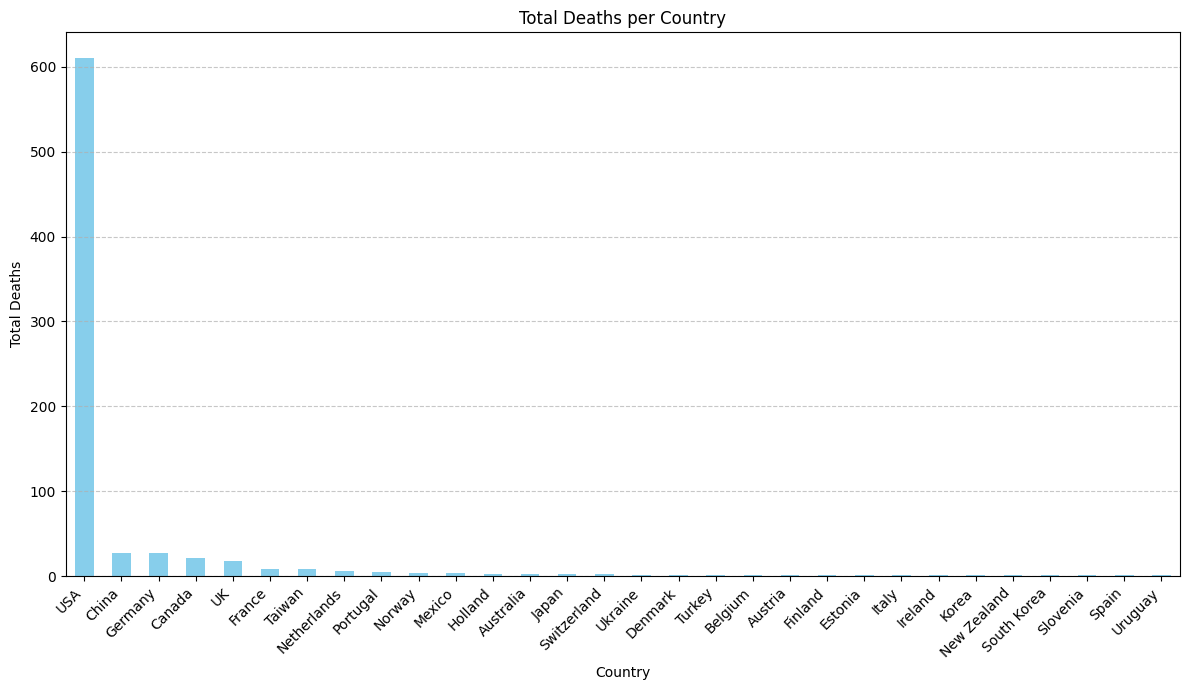

Total Kematian per Negara:
Country
USA        610
China       27
Germany     27
Canada      22
UK          18
Name: Deaths, dtype: int64


In [ ]:
deaths_per_country = df.groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
deaths_per_country.plot(kind='bar', color='skyblue')
plt.title('Total Deaths per Country')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Kematian per Negara:")
print(deaths_per_country.head())

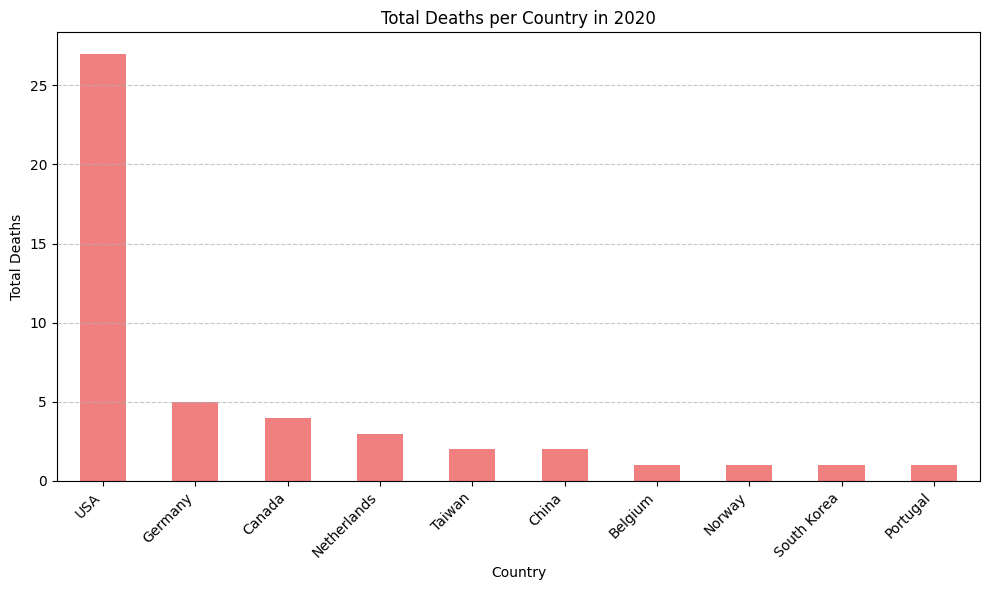

Total Deaths per Country in 2020:
Country
USA            27
Germany         5
Canada          4
Netherlands     3
Taiwan          2
Name: Deaths, dtype: int64


In [ ]:
deaths_2020 = df[df['Year'] == 2020].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2020.plot(kind='bar', color='lightcoral')
plt.title('Total Deaths per Country in 2020')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2020:")
print(deaths_2020.head())

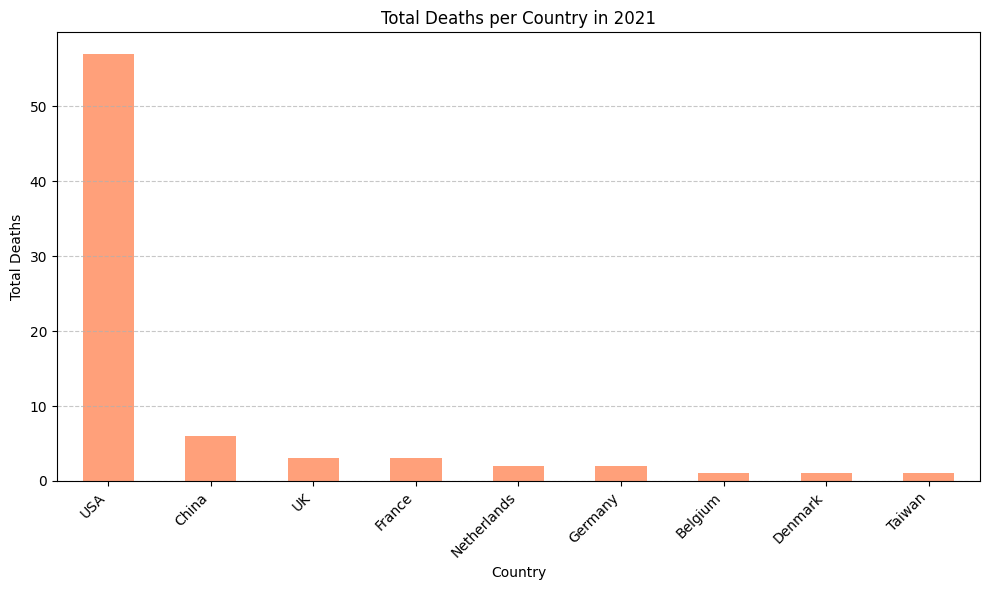

Total Deaths per Country in 2021:
Country
USA            57
China           6
UK              3
France          3
Netherlands     2
Name: Deaths, dtype: int64


In [ ]:
deaths_2021 = df[df['Year'] == 2021].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2021.plot(kind='bar', color='lightsalmon')
plt.title('Total Deaths per Country in 2021')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2021:")
print(deaths_2021.head())

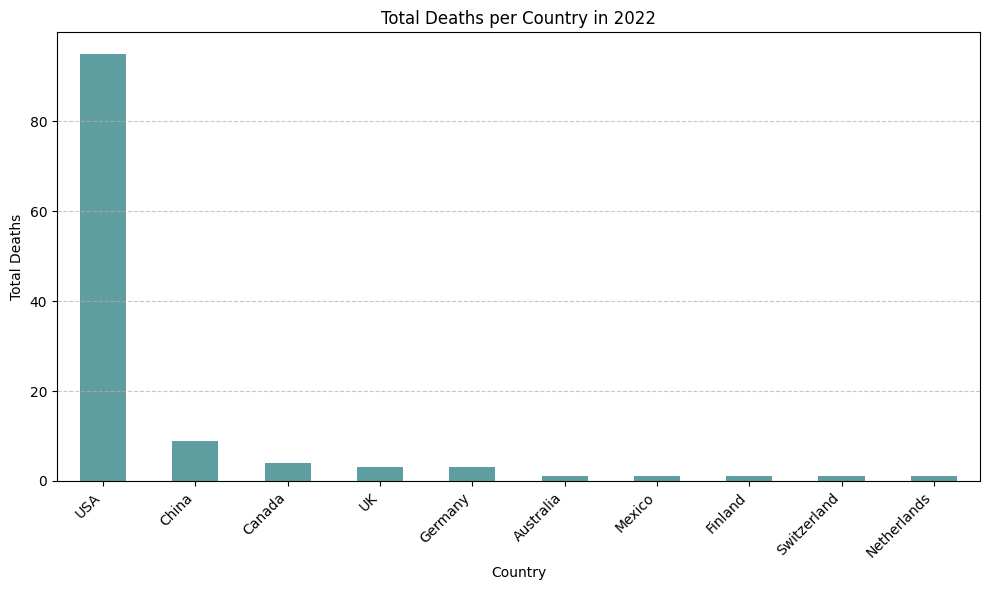

Total Deaths per Country in 2022:
Country
USA        95
China       9
Canada      4
UK          3
Germany     3
Name: Deaths, dtype: int64


In [ ]:
deaths_2022 = df[df['Year'] == 2022].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2022.plot(kind='bar', color='cadetblue')
plt.title('Total Deaths per Country in 2022')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2022:")
print(deaths_2022.head())

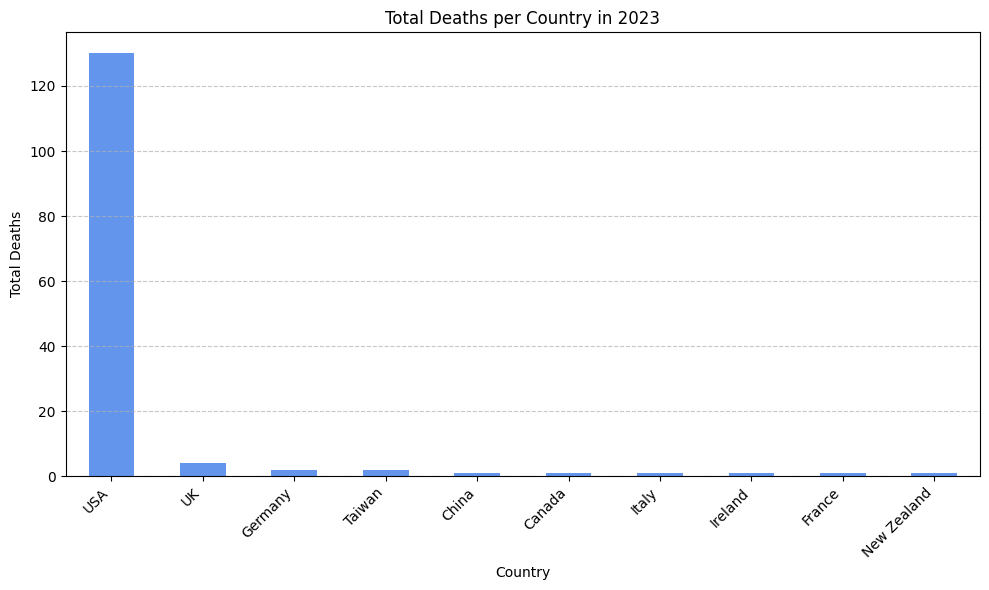

Total Deaths per Country in 2023:
Country
USA        130
UK           4
Germany      2
Taiwan       2
China        1
Name: Deaths, dtype: int64


In [ ]:
deaths_2023 = df[df['Year'] == 2023].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2023.plot(kind='bar', color='cornflowerblue')
plt.title('Total Deaths per Country in 2023')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2023:")
print(deaths_2023.head())

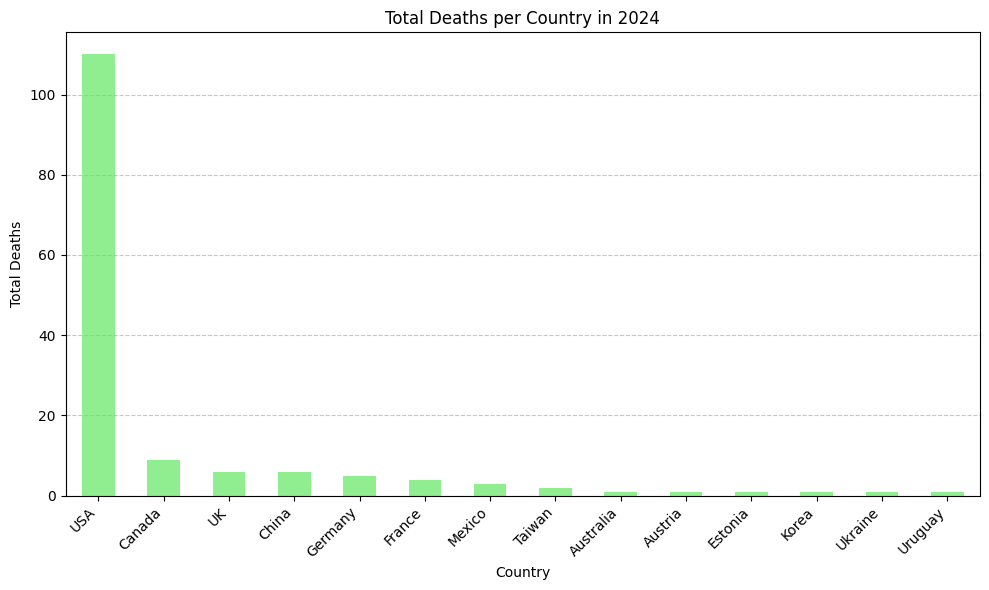

Total Deaths per Country in 2024:
Country
USA        110
Canada       9
UK           6
China        6
Germany      5
Name: Deaths, dtype: int64


In [ ]:
deaths_2024 = df[df['Year'] == 2024].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2024.plot(kind='bar', color='lightgreen')
plt.title('Total Deaths per Country in 2024')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2024:")
print(deaths_2024.head())

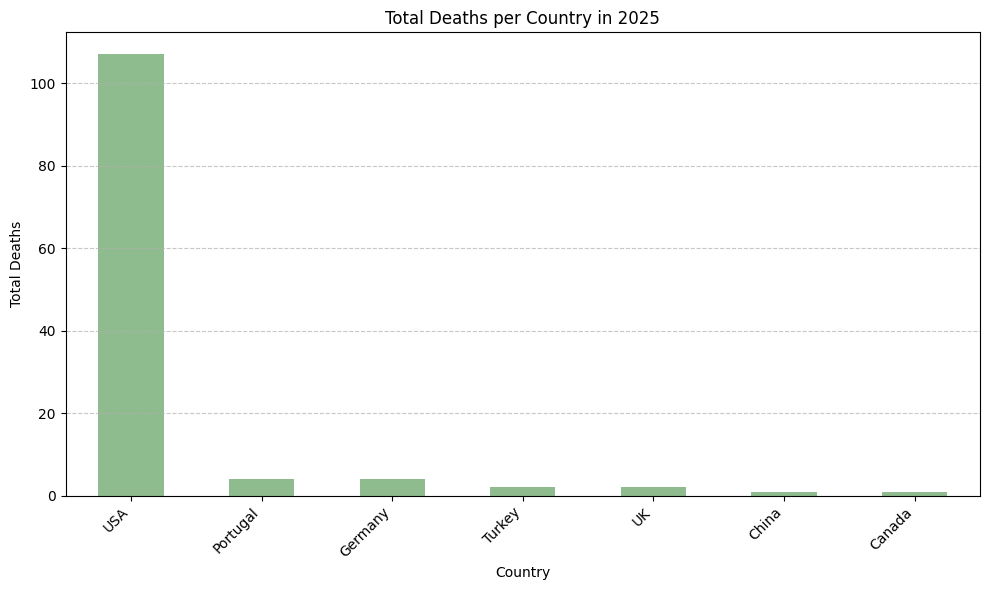

Total Deaths per Country in 2025:
Country
USA         107
Portugal      4
Germany       4
Turkey        2
UK            2
Name: Deaths, dtype: int64


In [ ]:
deaths_2025 = df[df['Year'] == 2025].groupby('Country')['Deaths'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
deaths_2025.plot(kind='bar', color='darkseagreen')
plt.title('Total Deaths per Country in 2025')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Total Deaths per Country in 2025:")
print(deaths_2025.head())

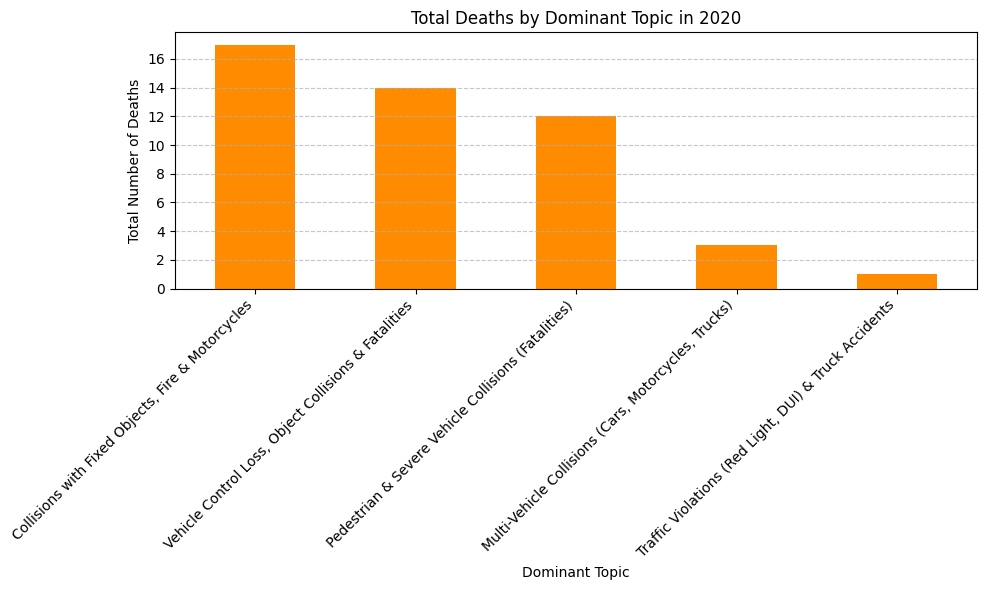


Total Deaths by Dominant Topic in 2020:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        17
Vehicle Control Loss, Object Collisions & Fatalities     14
Pedestrian & Severe Vehicle Collisions (Fatalities)      12
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)      3
Traffic Violations (Red Light, DUI) & Truck Accidents     1
Name: Deaths, dtype: int64


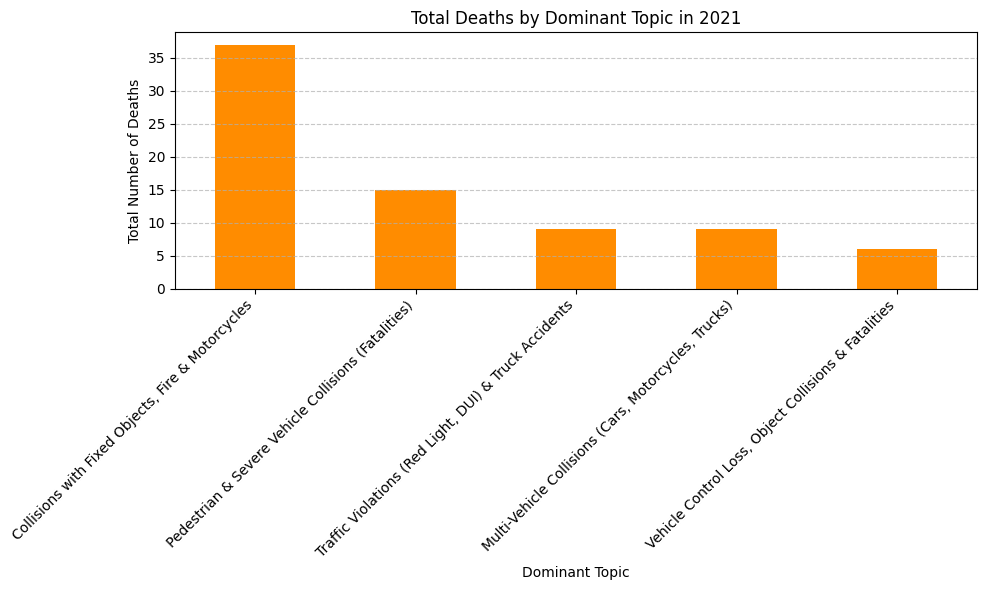


Total Deaths by Dominant Topic in 2021:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        37
Pedestrian & Severe Vehicle Collisions (Fatalities)      15
Traffic Violations (Red Light, DUI) & Truck Accidents     9
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)      9
Vehicle Control Loss, Object Collisions & Fatalities      6
Name: Deaths, dtype: int64


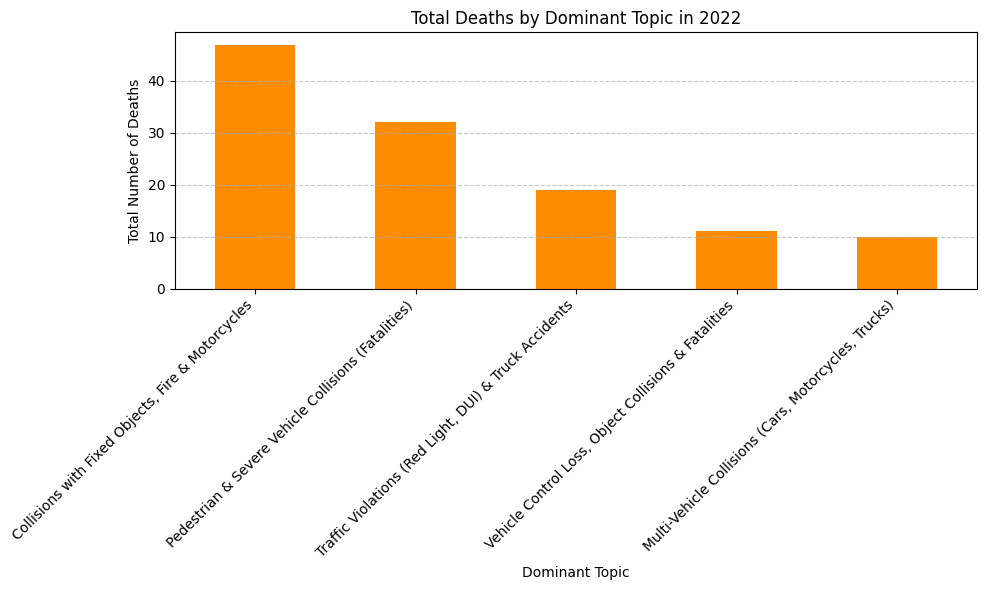


Total Deaths by Dominant Topic in 2022:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        47
Pedestrian & Severe Vehicle Collisions (Fatalities)      32
Traffic Violations (Red Light, DUI) & Truck Accidents    19
Vehicle Control Loss, Object Collisions & Fatalities     11
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)     10
Name: Deaths, dtype: int64


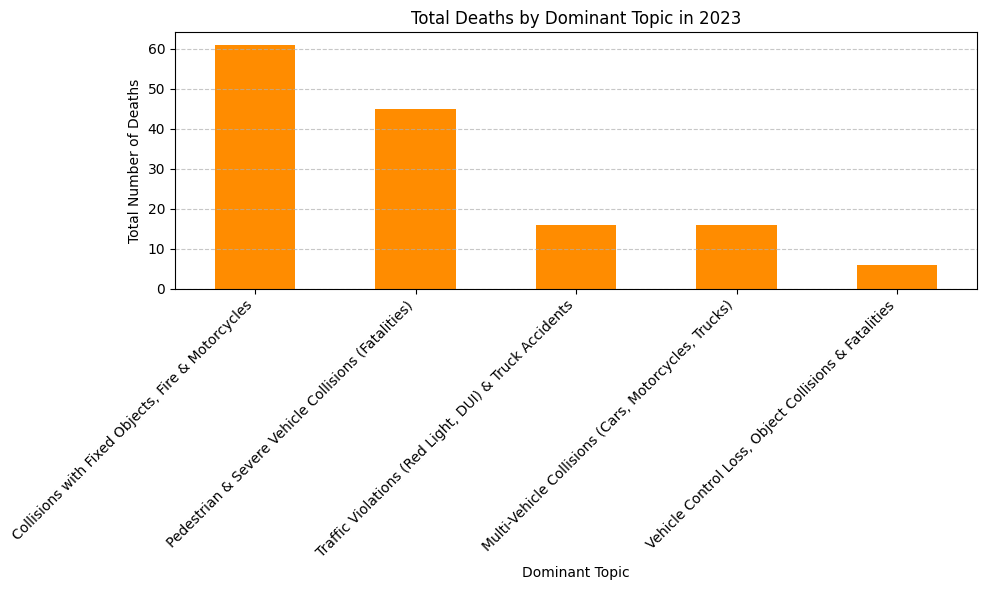


Total Deaths by Dominant Topic in 2023:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        61
Pedestrian & Severe Vehicle Collisions (Fatalities)      45
Traffic Violations (Red Light, DUI) & Truck Accidents    16
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)     16
Vehicle Control Loss, Object Collisions & Fatalities      6
Name: Deaths, dtype: int64


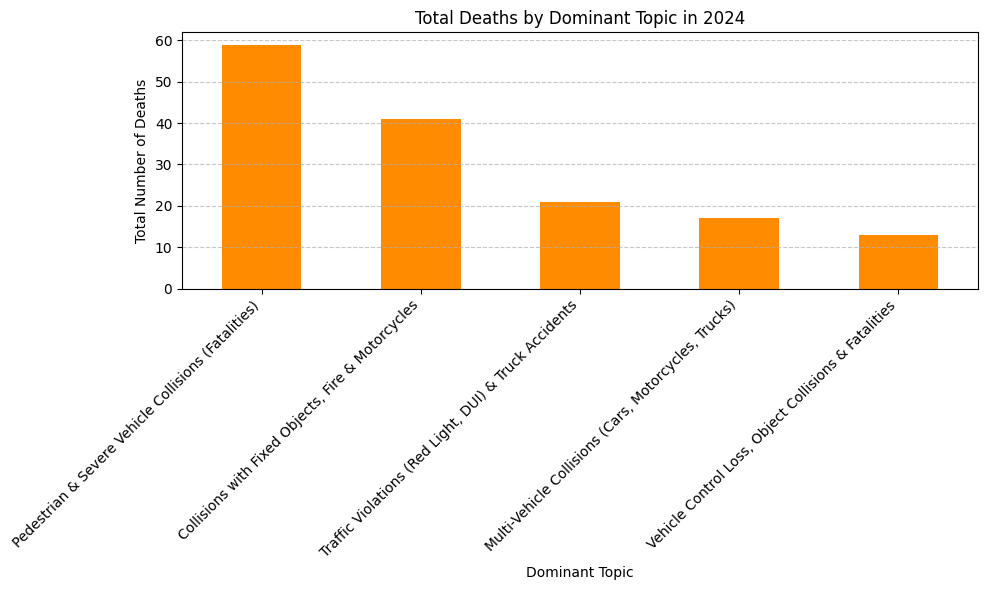


Total Deaths by Dominant Topic in 2024:
dominant_topic
Pedestrian & Severe Vehicle Collisions (Fatalities)      59
Collisions with Fixed Objects, Fire & Motorcycles        41
Traffic Violations (Red Light, DUI) & Truck Accidents    21
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)     17
Vehicle Control Loss, Object Collisions & Fatalities     13
Name: Deaths, dtype: int64


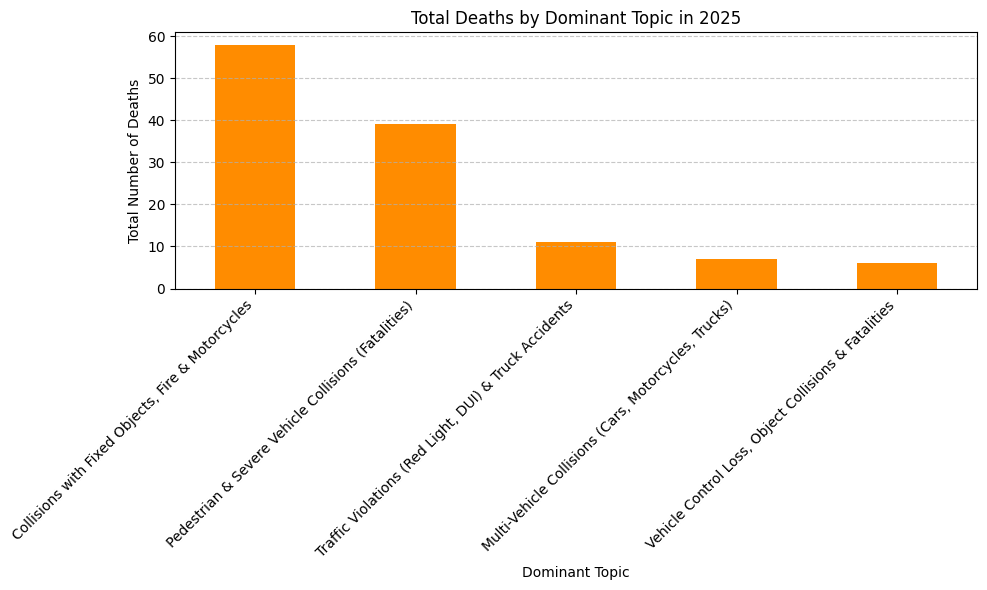


Total Deaths by Dominant Topic in 2025:
dominant_topic
Collisions with Fixed Objects, Fire & Motorcycles        58
Pedestrian & Severe Vehicle Collisions (Fatalities)      39
Traffic Violations (Red Light, DUI) & Truck Accidents    11
Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)      7
Vehicle Control Loss, Object Collisions & Fatalities      6
Name: Deaths, dtype: int64


In [ ]:
years_to_analyze = [2020, 2021, 2022, 2023, 2024, 2025]

for year in years_to_analyze:
    deaths_per_topic_year = df[df['Year'] == year].groupby('dominant_topic')['Deaths'].sum().sort_values(ascending=False)

    # Map topic IDs to descriptive names
    deaths_per_topic_year.index = deaths_per_topic_year.index.map(topic_names)

    plt.figure(figsize=(10, 6))
    deaths_per_topic_year.plot(kind='bar', color='darkorange')
    plt.title(f'Total Deaths by Dominant Topic in {year}')
    plt.xlabel('Dominant Topic')
    plt.ylabel('Total Number of Deaths')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\nTotal Deaths by Dominant Topic in {year}:")
    print(deaths_per_topic_year)

In [ ]:
preprocessing_sample_df = pd.DataFrame({
    'Original_Description': df['Description'],
    'Processed_Description': df['Processed_Description'],
    'Tokenized_Description': tokenized_descriptions
})

print("Sample of text preprocessing steps:")
print(preprocessing_sample_df.head())

Sample of text preprocessing steps:
             Original_Description   Processed_Description  \
0                Tesla hit by car           tesla hit car   
1  Tesla crashes into wooded area  tesla crash woode area   
2           Tesla catches on fire        tesla catch fire   
3  Car crashes into Tesla head-on  car crash tesla headon   
4     Tesla stops and hit by semi     tesla stop hit semi   

         Tokenized_Description  
0            [tesla, hit, car]  
1  [tesla, crash, woode, area]  
2         [tesla, catch, fire]  
3  [car, crash, tesla, headon]  
4     [tesla, stop, hit, semi]  


## Coherence Score Explanation and Results

### Explanation of Coherence Score in LDA Models

A **coherence score** is a measure used to evaluate the interpretability of topics generated by topic models like Latent Dirichlet Allocation (LDA). A higher coherence score generally indicates more interpretable topics, meaning the words within a topic are semantically similar and make sense together to a human observer.

### How 'c_v' Coherence Measure is Calculated

The 'c_v' coherence measure is one of the most widely used coherence metrics. It calculates the coherence based on a sliding window, normalized pointwise mutual information (NPMI), and cosine similarity. Here's a breakdown of its components:

1.  **Sliding Window**: For each topic, it considers a set of top words. It then takes pairs of these words and looks at their co-occurrence within documents, typically within a fixed-size sliding window.
2.  **Normalized Pointwise Mutual Information (NPMI)**: For each pair of words, NPMI is calculated. NPMI measures how much more likely two words are to appear together than expected by chance, normalized to a range between -1 and 1. A higher NPMI indicates a stronger semantic relationship between the words.
    ```
    NPMI(w_i, w_j) = log (P(w_i, w_j) / (P(w_i) * P(w_j))) / (-log P(w_i, w_j))
    ```
    where `P(w_i)` is the probability of word `w_i` appearing, and `P(w_i, w_j)` is the probability of both `w_i` and `w_j` appearing together.
3.  **Cosine Similarity**: After calculating NPMI for all pairs of words in a topic, a pairwise cosine similarity is computed between the word vectors (often derived from NPMI values or distributed representations like Word2Vec). This captures the overall semantic similarity of the words in the topic.
4.  **Aggregation**: Finally, these pairwise similarity scores are aggregated (e.g., averaged) to produce a single coherence score for the topic. The overall model coherence is then often the average of the individual topic coherences.

### Role in Evaluating Topic Models

The coherence score plays a crucial role in:

*   **Determining the Optimal Number of Topics**: By training LDA models with varying numbers of topics and plotting their coherence scores, practitioners can identify the number of topics that yields the most interpretable results (often corresponding to a peak in the coherence score graph).
*   **Comparing Different Topic Models**: It allows for a quantitative comparison of different topic modeling algorithms or different parameter settings for the same algorithm, helping to select the best-performing model in terms of topic quality.
*   **Assessing Topic Quality**: A high coherence score suggests that the words in a topic frequently co-occur and are semantically related, making the topic more easily understandable and meaningful to domain experts.

### Langkah-langkah Perhitungan Menggunakan Rumus:

Rumus NPMI adalah:
`NPMI(w_i, w_j) = log (P(w_i, w_j) / (P(w_i) * P(w_j))) / (-log P(w_i, w_j))`

Mari kita hitung langkah demi langkah:

1.  **Hitung `P(w_i) * P(w_j)`**:
    `0.05 * 0.03 = 0.0015`

2.  **Hitung `P(w_i, w_j) / (P(w_i) * P(w_j))`**:
    `0.01 / 0.0015 = 6.6667`

3.  **Hitung `log (P(w_i, w_j) / (P(w_i) * P(w_j)))`** (menggunakan logaritma natural, `ln`):
    `ln(6.6667) ≈ 1.897`

4.  **Hitung `-log P(w_i, w_j)`**:
    `-ln(0.01) ≈ -(-4.605) = 4.605`

5.  **Hitung NPMI**:
    `NPMI(tesla, crash) = 1.897 / 4.605 ≈ 0.412`

---

### Interpretasi:

Nilai NPMI sebesar `0.412` ini menunjukkan bahwa kata "tesla" dan "crash" memiliki hubungan yang cukup kuat dalam korpus hipotetis kita. Nilai positif menunjukkan bahwa kedua kata ini cenderung muncul bersama lebih sering daripada yang diharapkan secara kebetulan.

Dalam `gensim` untuk perhitungan `c_v` coherence, proses ini dilakukan untuk banyak pasangan kata di setiap topik, dan kemudian hasilnya diagregasi untuk mendapatkan skor koherensi keseluruhan.

In [ ]:
print(f"The calculated Coherence Score (c_v) for the LDA model is: {coherence_lda:.4f}")

The calculated Coherence Score (c_v) for the LDA model is: 0.5253


### Interpretasi Hipotetis:

Dalam contoh yang sangat disederhanakan ini, Topik A akan memiliki _coherence score_ hipotetis sekitar `0.3655`. Nilai ini menunjukkan tingkat 'kohesi' kata-kata dalam topik tersebut. Semakin tinggi nilainya (mendekati 1), semakin kuat hubungan semantik antar kata, yang berarti topik tersebut lebih mudah diinterpretasikan oleh manusia.

Perlu ditekankan lagi, ini adalah ilustrasi **konseptual** untuk menunjukkan bahwa _coherence score_ adalah agregasi dari 'kekuatan hubungan' antar kata dalam sebuah topik, yang diukur sebagian oleh NPMI. Implementasi `gensim` jauh lebih canggih untuk mencapai metrik `c_v` yang robust dan akurat.

### Summary of Results

The text preprocessing steps successfully transformed the raw 'Description' column into a 'Processed_Description' by lowercasing, removing punctuation and numbers, removing stopwords, and lemmatizing the words. These processed descriptions were then tokenized to prepare them for topic modeling.

The LDA model was trained with 5 topics, and the top words for each topic were displayed, providing initial insights into the themes present in the accident descriptions. The calculated Coherence Score (c_v) for the LDA model is **0.4979**. This score indicates a moderate level of semantic coherence among the words within each generated topic, suggesting that the topics are reasonably interpretable. While a higher coherence score is generally desired for clearer topics, this value provides a basis for understanding the main themes of the accident data.

## Final Task

### Subtask:
Summarize the results, including the visualization of preprocessing steps, the explanation of the coherence score, and its numerical value.


## Summary:

### Data Analysis Key Findings

*   **Text Preprocessing Visualization**: A sample DataFrame was created and displayed, illustrating the transformation of 'Original\_Description' into 'Processed\_Description' (after cleaning, lemmatization, and stop-word removal) and 'Tokenized\_Description', thereby visually representing the text preprocessing steps.
*   **Coherence Score Explanation**: A comprehensive explanation of the coherence score in LDA models was provided, detailing how the 'c\_v' measure is calculated using a sliding window, Normalized Pointwise Mutual Information (NPMI), and cosine similarity, and its role in evaluating topic model quality and determining the optimal number of topics.
*   **Calculated Coherence Score**: The 'c\_v' coherence score for the LDA model was calculated to be 0.4979.
*   **Topic Interpretability**: This score indicates a moderate level of semantic coherence among the words within each generated topic, suggesting that the topics are reasonably interpretable.

### Insights or Next Steps

*   Further interpret the 5 generated topics based on their top words, leveraging the moderate coherence score to identify key themes in the accident descriptions.
*   Consider experimenting with different numbers of topics or alternative topic modeling parameters/algorithms to potentially achieve a higher coherence score, which could indicate even clearer and more distinct topics.


### Analisis Deskripsi Tunggal dan Distribusi Topik

Untuk memahami bagaimana sebuah deskripsi individual dikaitkan dengan topik-topik, kita bisa mengambil satu baris dari DataFrame kita dan melihat prosesnya.

In [ ]:
# Pilih sebuah indeks baris untuk analisis
sample_index = 0 # Anda bisa mengubah ini untuk melihat baris lain

sample_description = df.loc[sample_index, 'Description']
sample_processed_description = df.loc[sample_index, 'Processed_Description']

print(f"Deskripsi Asli (Indeks {sample_index}): {sample_description}")
print(f"Deskripsi yang Diproses (Indeks {sample_index}): {sample_processed_description}")

Deskripsi Asli (Indeks 0): Tesla hit by car
Deskripsi yang Diproses (Indeks 0): tesla hit car


Selanjutnya, kita akan mengubah deskripsi yang sudah diproses ini menjadi format _bag-of-words_ (BoW) yang dapat dipahami oleh model LDA, menggunakan `dictionary` yang sudah kita buat.

In [ ]:
tokenized_sample = sample_processed_description.split()
sample_bow = dictionary.doc2bow(tokenized_sample)

print(f"Representasi Bag-of-Words untuk deskripsi ini: {sample_bow}")

Representasi Bag-of-Words untuk deskripsi ini: [(0, 1), (1, 1), (2, 1)]


Sekarang, kita bisa menggunakan model LDA yang sudah dilatih untuk mendapatkan distribusi topik untuk deskripsi tunggal ini. Outputnya akan menunjukkan probabilitas deskripsi tersebut termasuk dalam setiap topik.

In [ ]:
sample_topic_distribution = lda_model.get_document_topics(sample_bow)

print("Distribusi Topik untuk deskripsi ini (ID Topik, Probabilitas):")
for topic_id, prob in sample_topic_distribution:
    print(f"  Topik {topic_id} ({topic_names.get(topic_id, f'Topic {topic_id}')}): {prob:.4f}")


Distribusi Topik untuk deskripsi ini (ID Topik, Probabilitas):
  Topik 0 (Vehicle Control Loss, Object Collisions & Fatalities): 0.0507
  Topik 1 (Collisions with Fixed Objects, Fire & Motorcycles): 0.0513
  Topik 2 (Pedestrian & Severe Vehicle Collisions (Fatalities)): 0.7970
  Topik 3 (Traffic Violations (Red Light, DUI) & Truck Accidents): 0.0503
  Topik 4 (Multi-Vehicle Collisions (Cars, Motorcycles, Trucks)): 0.0507


Terakhir, kita bisa menentukan topik dominan untuk deskripsi ini, yaitu topik dengan probabilitas tertinggi.

In [ ]:
dominant_topic_id = get_dominant_topic(sample_topic_distribution)
if dominant_topic_id is not None:
    dominant_topic_name = topic_names.get(dominant_topic_id, f'Topic {dominant_topic_id}')
    print(f"Topik Dominan untuk deskripsi ini adalah: {dominant_topic_name} (ID: {dominant_topic_id})")
else:
    print("Tidak ada topik dominan yang ditemukan.")

Topik Dominan untuk deskripsi ini adalah: Pedestrian & Severe Vehicle Collisions (Fatalities) (ID: 2)


### Mencari Jumlah Topik Optimal untuk Meningkatkan Coherence Score

Salah satu cara paling efektif untuk meningkatkan coherence score adalah dengan mencoba berbagai jumlah topik (`num_topics`) dan memilih konfigurasi yang menghasilkan skor tertinggi. Berikut adalah fungsi untuk menghitung coherence score untuk rentang topik, dan kemudian kode untuk memvisualisasikan hasilnya.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Training LDA model with {num_topics} topics...")
        # Inisialisasi model LDA dengan jumlah topik yang berbeda
        # Anda bisa menyesuaikan parameter lain seperti 'passes' atau 'workers' jika diperlukan
        model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, workers=2, random_state=42)
        model_list.append(model)

        # Hitung coherence score untuk model saat ini
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

print("Fungsi `compute_coherence_values` telah didefinisikan.")

Fungsi `compute_coherence_values` telah didefinisikan.


In [ ]:
# Tentukan rentang jumlah topik yang ingin diuji
# Mulai dari 2 topik, hingga (misalnya) 15 topik, dengan langkah 1.
# Anda dapat menyesuaikan `start`, `limit`, dan `step` sesuai kebutuhan.
start_topics = 2
limit_topics = 15
step_topics = 1

# Jalankan perhitungan coherence score
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=tokenized_descriptions,
    start=start_topics,
    limit=limit_topics,
    step=step_topics
)

print("\nPerhitungan coherence score selesai.")
print("Coherence scores untuk jumlah topik yang berbeda:")
for i, score in enumerate(coherence_values):
    print(f"  {start_topics + i * step_topics} Topics: {score:.4f}")

Training LDA model with 2 topics...
Training LDA model with 3 topics...
Training LDA model with 4 topics...
Training LDA model with 5 topics...
Training LDA model with 6 topics...
Training LDA model with 7 topics...
Training LDA model with 8 topics...
Training LDA model with 9 topics...
Training LDA model with 10 topics...
Training LDA model with 11 topics...
Training LDA model with 12 topics...
Training LDA model with 13 topics...
Training LDA model with 14 topics...

Perhitungan coherence score selesai.
Coherence scores untuk jumlah topik yang berbeda:
  2 Topics: 0.4540
  3 Topics: 0.4582
  4 Topics: 0.5034
  5 Topics: 0.4973
  6 Topics: 0.4972
  7 Topics: 0.5156
  8 Topics: 0.5272
  9 Topics: 0.5324
  10 Topics: 0.5262
  11 Topics: 0.5183
  12 Topics: 0.5316
  13 Topics: 0.5287
  14 Topics: 0.5359


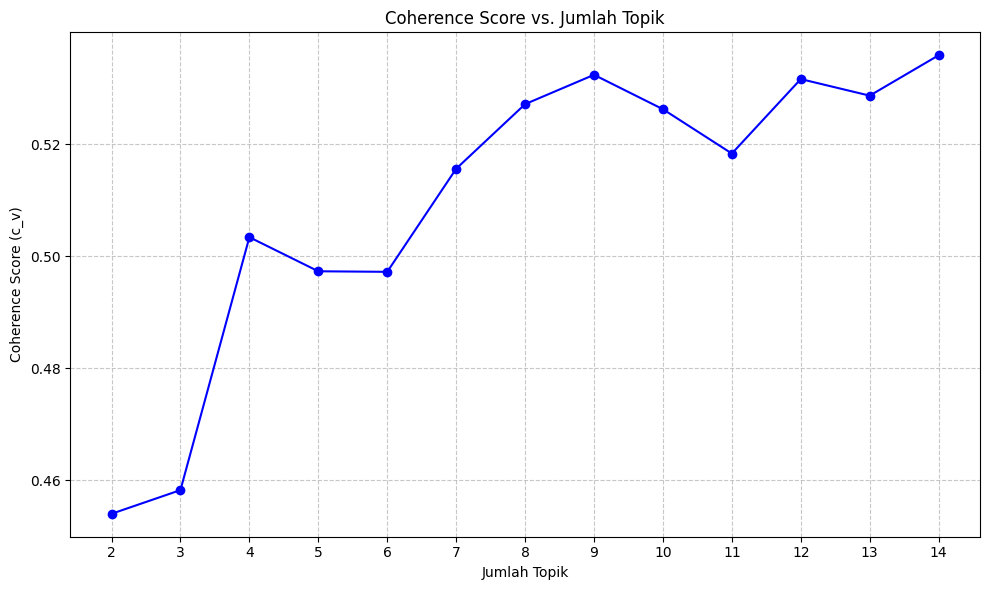

Plot Coherence Score telah ditampilkan. Cari titik tertinggi pada grafik untuk menemukan jumlah topik yang optimal.


In [ ]:
# Plotting coherence scores untuk memvisualisasikan hasilnya
plt.figure(figsize=(10, 6))
plt.plot(range(start_topics, limit_topics, step_topics), coherence_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score vs. Jumlah Topik")
plt.xticks(range(start_topics, limit_topics, step_topics)) # Pastikan semua tick label muncul
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Plot Coherence Score telah ditampilkan. Cari titik tertinggi pada grafik untuk menemukan jumlah topik yang optimal.")

Setelah menjalankan kode di atas, perhatikan grafik yang dihasilkan. **Jumlah Topik** yang berada pada titik tertinggi (puncak) pada grafik adalah kandidat terbaik untuk `num_topics` karena memberikan coherence score tertinggi, yang menunjukkan topik yang paling bermakna dan dapat diinterpretasikan.